Import Packages

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc

!pip install mord
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns

!pip install dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=98231a902cdc073415dd60c03895eee8b667c8f227ac55871a809cd659fa8535
  Stored in directory: /root/.cache/pip/wheels/1d/94/48/b3d11f5f91d26bec0c95c6eb9c27c6e427d0b77fb2406d0e0a
Successfully built mord
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 38.0 MB/s eta 0:00:00
no display found. Using non-interactive Agg backend


Data Exploration

In [ ]:
mowers = pd.read_csv('RidingMowers.csv')

In [ ]:
mowers.shape

(24, 3)

In [ ]:
mowers.head()

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner


1. What percentage of households in the study were owners of a riding mower? 

In [ ]:
count = mowers.Ownership.value_counts()
num_households = len(mowers)

In [ ]:
percentages = (count / num_households)
percentages

Owner       0.5
Nonowner    0.5
Name: Ownership, dtype: float64

_Answer:_<br>
50% of the households owns a riding mower.

---



2.	Use all the data to fit a logistic regression of ownership on the two predictors. Remember to create dummy variables, if appropriate.

In [ ]:
# Create a flag for ownership
mowers.Ownership = [1 if a=='Owner' else 0 for a in mowers.Ownership]

In [ ]:
X= pd.get_dummies(mowers.drop(columns='Ownership'), drop_first=True)
y= mowers['Ownership']

In [ ]:
# Split the data set
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size =0.4, random_state=1)

In [ ]:
# Declare Model
logit_reg = LogisticRegression(random_state=1, C=1, solver='liblinear')

In [ ]:
# fit model
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1, random_state=1, solver='liblinear')

In [ ]:
# probabilities
logit_reg_proba = logit_reg.predict_proba(valid_X)

In [ ]:
#predictions
logit_reg_pred = logit_reg.predict(valid_X)

In [ ]:
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.4000)

       Prediction
Actual 0 1
     0 3 3
     1 3 1


In [ ]:
logit_result = pd.DataFrame({'actual' : valid_y, 
                             'predicted': logit_reg_pred,
                             'p_0': [p[0] for p in logit_reg_proba],
                             'p_1': [p[1] for p in logit_reg_proba]})
logit_result

,actual,predicted,p_0,p_1
13,0,0,0.738075,0.261925
18,0,1,0.466319,0.533681
3,1,0,0.636731,0.363269
14,0,1,0.443508,0.556492
20,0,0,0.642792,0.357208
17,0,0,0.666402,0.333598
10,1,0,0.791980,0.208020
4,1,1,0.411572,0.588428
2,1,0,0.626267,0.373733
19,0,1,0.477580,0.522420


In [ ]:
# sort the dataframe by p_1
sorted = logit_result.sort_values(by=['p_1'], ascending=False)
sorted

,actual,predicted,p_0,p_1
4,1,1,0.411572,0.588428
14,0,1,0.443508,0.556492
18,0,1,0.466319,0.533681
19,0,1,0.477580,0.522420
2,1,0,0.626267,0.373733
3,1,0,0.636731,0.363269
20,0,0,0.642792,0.357208
17,0,0,0.666402,0.333598
13,0,0,0.738075,0.261925
10,1,0,0.791980,0.208020


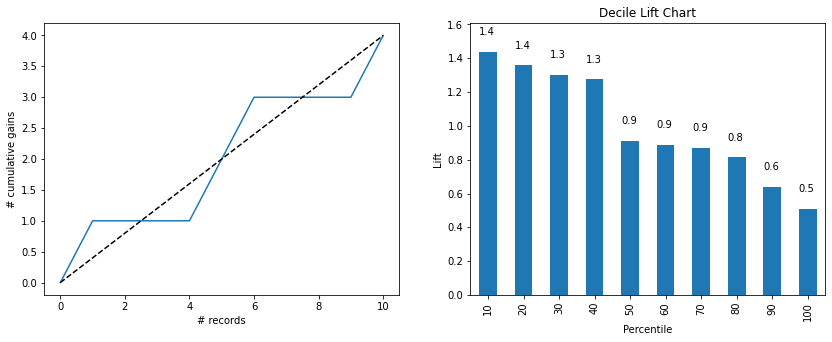

In [ ]:
fig, axes = plt.subplots(1,2, figsize =(14,5))
gainsChart(sorted.actual, ax=axes[0])
liftChart(sorted['p_1'], ax=axes[1])
fig



---

3. Among nonowners, what is the percentage of households classified correctly? 

In [ ]:
mowers['prediction'] = logit_reg.predict(mowers.drop(columns='Ownership'))

In [ ]:
# Filter by non owners
non_owners = mowers[mowers['Ownership']==0]
non_owners

,Income,Lot_Size,Ownership,prediction
12,75.0,19.6,0,1
13,52.8,20.8,0,0
14,64.8,17.2,0,1
15,43.2,20.4,0,0
16,84.0,17.6,0,1
17,49.2,17.6,0,0
18,59.4,16.0,0,1
19,66.0,18.4,0,1
20,47.4,16.4,0,0
21,33.0,18.8,0,0


In [ ]:
classificationSummary(non_owners.Ownership, logit_reg.predict(non_owners.drop(columns=['Ownership','prediction'])))

Confusion Matrix (Accuracy 0.4167)

       Prediction
Actual 0 1
     0 5 7
     1 0 0


In [ ]:
# Manual Calculation for Checking
prediction_count = non_owners.prediction.value_counts()
count_nonowners = len(non_owners)

In [ ]:
percentage_nonowners = prediction_count/count_nonowners
percentage_nonowners 

1    0.583333
0    0.416667
Name: prediction, dtype: float64

_Answer:_<br>
41.67% of non owners were classified correctly.


---



4. What is the probability that a household with a $60K income and a lot size of 20,000 ft2 is an owner? 

In [ ]:
new_df = pd.DataFrame([{'Income':60, 'Lot_Size':20}])
new_df

,Income,Lot_Size
0,60,20


In [ ]:
new_df_proba = logit_reg.predict_proba(new_df)
new_df_pred = logit_reg.predict(new_df)

In [ ]:
new_df = pd.DataFrame({'Income':60, 'Lot_Size':20,
                        'predicted': new_df_pred,
                        'p_0': [p[0] for p in new_df_proba],
                        'p_1': [p[1] for p in new_df_proba]})
new_df

,Income,Lot_Size,predicted,p_0,p_1
0,60,20,0,0.624323,0.375677


_Answer:_<br>
The probability of owning a mower with an household of $60k income and a lot size of 20,000ft.sq is **37.56%**.


---



5.	What is the classification of a household with a $60K income and a lot size of 20,000 ft.sq? Use cutoff = 0.5. 

In [ ]:
# Filter the data set with $60k Income and 20,000ft.sq Lot Size
df_60_20 = mowers[(mowers['Income'] >= 60) & (mowers['Lot_Size']>=20)]
df_60_20

,Income,Lot_Size,Ownership,prediction
2,64.8,21.6,1,0
3,61.5,20.8,1,0
4,87.0,23.6,1,1
7,82.8,22.4,1,1
8,69.0,20.0,1,0
9,93.0,20.8,1,1
11,81.0,20.0,1,1


In [ ]:
# Get the probabilities of the filtered Data set
df_60_20_proba= logit_reg.predict_proba(df_60_20[['Income','Lot_Size']])


In [ ]:
# Combine the probabilities to the dataset
df2 = pd.DataFrame({'Income': df_60_20.Income, 'Lot_Size':df_60_20.Lot_Size,
                    'Ownership':df_60_20.Ownership,
                        'p_1': [p[1] for p in df_60_20_proba]})
df2

,Income,Lot_Size,Ownership,p_1
2,64.8,21.6,1,0.373733
3,61.5,20.8,1,0.363269
4,87.0,23.6,1,0.588428
7,82.8,22.4,1,0.581990
8,69.0,20.0,1,0.495803
9,93.0,20.8,1,0.760939
11,81.0,20.0,1,0.654320


In [ ]:
# cutoff of 0.5
df2[df2['p_1']>=.5]

,Income,Lot_Size,Ownership,p_1
4,87.0,23.6,1,0.588428
7,82.8,22.4,1,0.581990
9,93.0,20.8,1,0.760939
11,81.0,20.0,1,0.654320


In [ ]:
classificationSummary(df2.Ownership, logit_reg.predict(df2.drop(columns=['Ownership','p_1'])))

Confusion Matrix (Accuracy 0.5714)

       Prediction
Actual 0 1
     0 0 0
     1 3 4


The classification of households with $60k income, 20,000ft.sq lot size and a cutoff of 0.5 is 57.14%.